# Numerical Methods for Partial Differential Equations.

TMA4125 Vår 2022

This notebook accompanies the slides [11-Numerical-Methods-for-PDEs.pdf](https://www.math.ntnu.no/emner/TMA4125/2022v/lecture-notes/11-Numerical-Methods-for-PDEs.pdf).

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy.linalg as la # Solve linear systems
import matplotlib.animation as animation
from IPython.display import HTML

newparams = {'figure.figsize': (8.0, 4.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 12}
plt.rcParams.update(newparams)

## Numerical Differentiation
(cf. slide 5)

We consider $f(x) = \sin(x)$ at $x=\frac{\pi}{4}$ where we can compare with the exact derivative.

**Exercise** try different step sizes of $h$, for example $0.1$, $0.01$ and $0.001$

In [2]:
def diff_forward(f, x, h=0.1):
    """
        diff_forward(f,x,h=0.1)

        Compute the forward difference approximation of $f'(x)$.
    """
    return (f(x+h)-f(x))/h

def diff_backward(f, x, h=0.1):
    """
        diff_backward(f,x,h=0.1)

        Compute the forward difference approximation of $f'(x)$.
    """
    return (f(x)-f(x-h))/h
 
def diff_central(f, x, h=0.1):
    """
        diff_central(f,x,h=0.1)

        Compute the central difference approximation of $f'(x)$.
    """
    return (f(x+h)-f(x-h))/(2*h)

def diff2_central(f, x, h=0.1):
    """
        diff2_central(f,x,h=0.1)

        Compute the central difference approximation of $f''(x)$.
    """
    return (f(x+h)-2*f(x)+f(x-h))/h**2

In [3]:
#
# Numerical Example 1
#
x = np.pi/4
df_exact = np.cos(x)
ddf_exact = -np.sin(x)
h = 0.1
f = np.sin
df = diff_forward(f, x, h)
print('Approximations to the first derivative with h={:1.4f}'.format(h))
print('Forward difference:  df = {:12.8f},   Error = {:10.3e} '.format(
    df, df_exact-df))
df = diff_backward(f, x, h)
print('Backward difference: df = {:12.8f},   Error = {:10.3e} '.format(
    df, df_exact-df))
df = diff_central(f, x, h)
print('Central difference:  df = {:12.8f},   Error = {:10.3e} '.format(
    df, df_exact-df))
print('Approximation to the second derivative')
ddf = diff2_central(f, x, h)
print('Central difference:  ddf= {:12.8f},   Error = {:10.3e} '.format(
    ddf, ddf_exact-ddf))

Approximations to the first derivative with h=0.1000
Forward difference:  df =   0.67060297,   Error =  3.650e-02 
Backward difference: df =   0.74125475,   Error = -3.415e-02 
Central difference:  df =   0.70592886,   Error =  1.178e-03 
Approximation to the second derivative
Central difference:  ddf=  -0.70651772,   Error = -5.891e-04 


## 1D Poisson Problem
(cf. Slide 11)



In [4]:

def fdm_poisson1d_matrix(N):
    """
        fdm_poisson1d_matrix(N)

    Computes the finite difference matrix (fdm) for the Poisson problem in 1D

    Parameters:
    N (int): Number of grid points :math:`\{x_i}_{i=0}^N` counting from 0.

    Returns:
    A (ndarray): Finite difference matrix 

    """
    h = 1.0/N # Gridsize
    # Define zero matrix A of right size and insert
    A = np.zeros((N+1, N+1))
    # Define tridiagonal part of A
    hsq = h*h
    for i in range(1, N):
        A[i, i-1] = -1/hsq
        A[i, i] = 2/hsq
        A[i, i+1] = -1/hsq
    # Set a_00 = a_NN to 1 to incorporate boundary condition
    A[0, 0] = 1
    A[N, N] = 1
    return A

def apply_bcs(b, bcs):
    """
        apply_bcs(F, bcs)

    Incorporate boundary conditions into rhs vector `b`
    """
    b[0], b[-1] = bcs[0], bcs[1]

In [5]:
# Analytical reference solution (we also take the boundary conditions from here)
def u(x): return np.sin(2*np.pi*x)
# right hand side and discretisation N
def f(x): return (2*np.pi)**2*np.sin(2*np.pi*x)
N = 10
# Define grid points
x = np.linspace(0, 1, N+1)
xfine = np.linspace(0, 1, 10*N) # for plotting

In [6]:
# Compute A and b
A = fdm_poisson1d_matrix(N)
F = f(x)  
# Incorporate bcs - taken from the solution
bcs = [u(0), u(1)]
apply_bcs(F, bcs)

# Solve AU = b
U = la.solve(A, F)

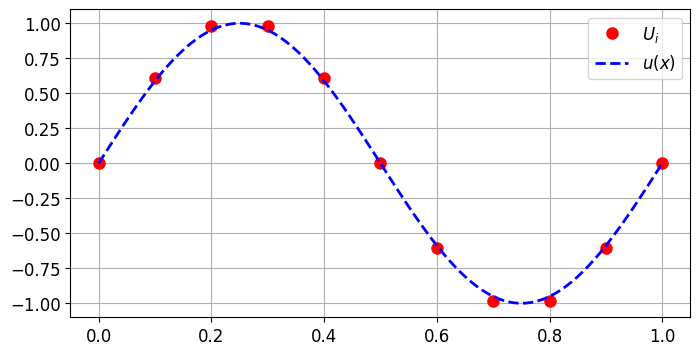

In [7]:
# Lets plot our discrete solution U
plt.plot(x, U, "or", label="$U_i$")
# and compare it to the true solution
plt.plot(xfine, u(xfine), "--b", label="$u(x)$")
plt.legend()
plt.show()

## Two Point Boundary Problem
(slide 14)

We simplify the code a little bit by assuming $p(x)=p$ and $q(x)=q$ are just constants. Then the super and subdiagonal are constants.
Otherwise this code follows the roadmap of the previous problems:

Given $N$, $p$, $q$, $r(x)$ as well as $a,b$ and the boundary conditions $u_a,u_b$ we setup the linear system, which we then solve.

In [8]:
def tridiag(v, d, w, N):
    """
        A = tridiag(v,d,w,N)

    create a tridiagonal matrix with diagonal d, subdiagonal v and super diagonal w
    which are al constant single values
    """
    e = np.ones(N)        # array [1,1,...,1] of length N
    A = v*np.diag(e[1:],-1)+d*np.diag(e)+w*np.diag(e[1:],1)
    return A

In [10]:
# Example 1, BVP
# Define the equation
# u'' + p*u' + q*u = r(x) on the interval [a,b]
# Boundary condition: u(a)=ua and u(b)=ub
p = 2
q = -3
def r(x):
    return 9*x
a, b = 0, 1
ua, ub = 1, np.exp(-3) + 2*np.exp(1)-5

In [11]:
#Here we know the exact solution
def u(x):
    return np.exp(-3*x) + 2*np.exp(x) - 3*x - 2
# And we set N
N=4

In [12]:
#
# Discretization
#
h = (b-a)/N                # Stepsize
x = np.linspace(a, b, N+1) # The gridpoints x_0=a, x_1=a+h, .... , x_N=b

# Make a draft of the A-matrix (first and last row have to be adjusted)
v = 1-0.5*h*p              # Subdiagonal
d = -2+h**2*q              # Diagonal
w = 1+0.5*h*p              # Superdiagonal
A = tridiag(v, d, w, N+1)

# Make a draft of the b-vector
F = h**2*r(x)

# Modify the first equation (left boundary)
A[0, 0] = 1
A[0, 1] = 0
# Modify the last equation (right boundary)
A[N, N] = 1
A[N, N-1] = 0

apply_bcs(F,[ua,ub]) #see definition above

In [13]:
U = la.solve(A, F)  # Solve the equation

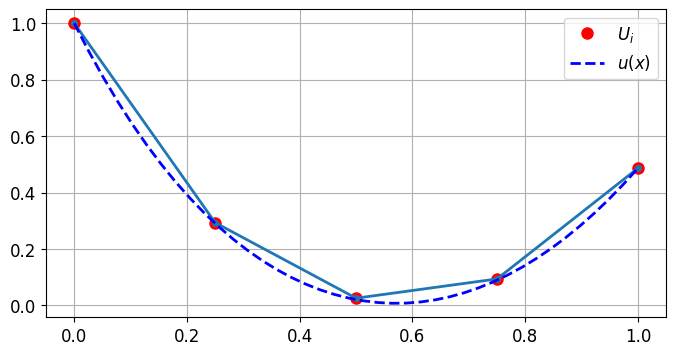

In [14]:
# Plot the solution of the BVP
xfine = np.linspace(a, b, 10*N)
plt.plot(x, U, "or", label="$U_i$")
plt.plot(x, U, ".-")
# and compare it to the true solution
plt.plot(xfine, u(xfine), "--b", label="$u(x)$")
plt.legend()
plt.show()


Max error = 4.985e-03


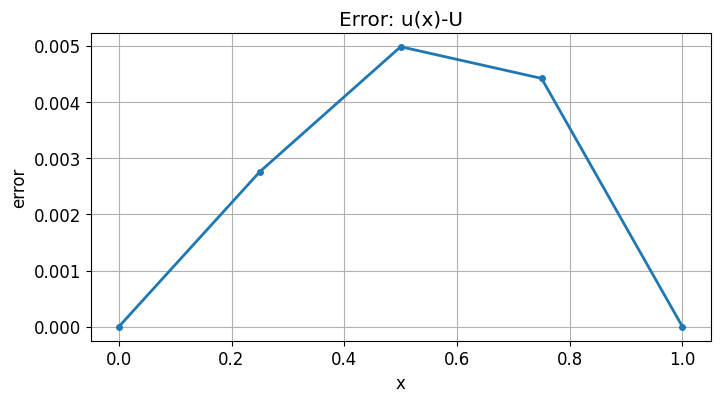

In [15]:
# Let‘s take a look at the error
error = np.abs(u(x)-U)
plt.plot(x, error, '.-')
plt.xlabel('x')
plt.ylabel('error')
plt.title('Error: u(x)-U')
print('Max error = {:.3e}'.format(max(abs(error))))

## The Heat equation
(cf. slide 26 & 27)

We start with a helper function to plot the result.

In [16]:
def plot_heat_solution(x, t, U, txt='Solution of the Heat Equation'):
    """
        plot_heat_solution(x,t,U,txt="Solution of the Heat Equation")
    
    A small helper function to plot the solution of the heat equation given
    * the discretisaiton in space `x`
    * the discretisation in time `t`
    * on the meshgrid of the $(x_i, t_j)$ the computed values $U$
    * and an optional title for the figure
    """

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    T, X = np.meshgrid(t, x)
    # ax.plot_wireframe(T, X, U)
    ax.plot_surface(T, X, U, cmap=cm.coolwarm)
    ax.view_init(azim=30)              # Rotate the figure
    plt.xlabel('t')
    plt.ylabel('x')
    plt.title(txt)

In [17]:
# Initial conditions (for both examples, slides 26, 27)
def f1(x): # Example 1
    return np.sin(np.pi*x)
def f2(x): # Example 2
    y = 2*x
    y[x > 0.5] = 2-2*x[x >0.5]
    return y
# This line chooses which example we do
f = f1

In [18]:
# (zero) Boundary conditions
def g0(t):
    return 0
def g1(t):
    return 0

In [19]:

# Solve the heat equation by a forward difference in time (forward Euler)
# 
# (a) setup 
M = 4                         # Number of intervals in the x-direction
h = 1/M                       # step size in space
x = np.linspace(0, 1, M+1)    # Gridpoints in the x-direction

tend = 0.5
N = 20                        # Number of intervals in the t-direction
k = tend/N                    # Time step size k  
t = np.linspace(0, tend, N+1) # Gridpoints in the t-direction

In [20]:
#
# (b) setup Forward Euler and run the Algorithm

# Array to store the solution
U = np.zeros((M+1, N+1))
U[:, 0] = f(x)              # Initial condition U_{i,0} = f(x_i)

r = k/h**2
print('r =', r)

# Compute the steps in Forward Euler
for n in range(N):
    U[1:-1, n+1] = U[1:-1, n] + r*(U[2:, n]-2*U[1:-1, n]+U[0:-2, n])
    U[0, n+1] = g0(t[n+1])
    U[M, n+1] = g1(t[n+1])


r = 0.4


In [21]:
#%matplotlib inline
#%matplotlib widget
# Plot the numerical solution
plot_heat_solution(x, t, U)

TypeError: gca() got an unexpected keyword argument 'projection'

<Figure size 800x400 with 0 Axes>

C:\Users\alexl\AppData\Local\Temp\ipykernel_13668\902039532.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


Maximum error: 2.899e-02


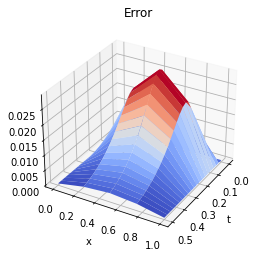

In [ ]:
# Plot the error from example 1
def u(x,t):
    return np.exp(-np.pi**2*t)*np.sin(np.pi*x)
T, X = np.meshgrid(t, x)
error = u(X, T) - U
plot_heat_solution(x, t, error, txt='Error')
# Maximal error over the whole array
print('Maximum error: {:.3e}'.format(max(abs(error.flatten()))))

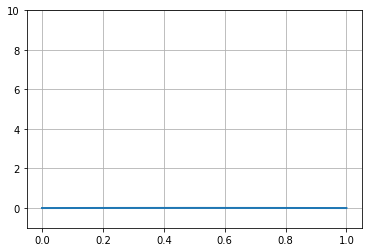

In [ ]:
#%%capture #do not output animation here
fig, ax = plt.subplots();
line, = ax.plot(x, U[:,0]);
ax.set_ylim([-1, 10]);

def animate(i):
    line.set_ydata(U[:,i])  # update the data, loop through time steps.
    return line,

ani = animation.FuncAnimation(fig, animate, interval=200, blit=True, frames=N+1)

HTML(ani.to_jshtml()) #transform to a nice video setup

## Implicit Methods: Implicit Euler and/or Crank-Nicolson
(slide 33)

In [ ]:
def f3(x):
    return np.cos(np.pi*x)

# Boundary values
def g0(t):
    return np.exp(-np.pi**2*t)
def g1(t):
    return -np.exp(-np.pi**2*t)

# Exact solution 
def u(x,t):
    return np.exp(-np.pi**2*t)*np.cos(np.pi*x)

f = f3

In [ ]:
# Choose method
method = 'iEuler'
# method = 'CrankNicolson'

M = 100                   # Number of intervals in the x-direction
h = 1/M
x = np.linspace(0,1,M+1)   # Gridpoints in the x-direction

tend = 0.5
N = M                 #  Number of intervals in the t-direction
k = tend/N
t = np.linspace(0,tend,N+1) # Gridpoints in the t-direction

# Array to store the solution
U = np.zeros((M+1,N+1))
U[:,0] = f(x)              # Initial condition U_{i,0} = f(x_i)

# Set up the matrix K: 
A = tridiag(1, -2, 1, M-1)
r = k/h**2
print('r = ', r)
if method == 'iEuler':
    K = np.eye(M-1) - r*A
elif method == 'CrankNicolson':
    K = np.eye(M-1) - 0.5*r*A

Utmp = U[1:-1,0]          # Temporary solution for the inner gridpoints. 

# Main loop over the time steps. 
for n in range(N):
    # Set up the right hand side of the equation KU=b:
    if method == 'iEuler':
        b = np.copy(Utmp)                   # NB! Copy the array
        b[0] = b[0] + r*g0(t[n+1])
        b[-1] = b[-1] + r*g1(t[n+1])  
    elif method == 'CrankNicolson':
        b = np.dot(np.eye(M-1)+0.5*r*A, Utmp)
        b[0] = b[0] + 0.5*r*(g0(t[n])+g0(t[n+1]))
        b[-1] = b[-1] + 0.5*r*(g1(t[n])+g1(t[n+1]))  
    
    Utmp = la.solve(K,b)         # Solve the equation K*Utmp = b
    
    U[1:-1,n+1] = Utmp        # Store the solution
    U[0, n+1] = g0(t[n+1])    # Include the boundaries. 
    U[M, n+1] = g1(t[n+1])

r =  50.0


C:\Users\alexl\AppData\Local\Temp\ipykernel_13668\902039532.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


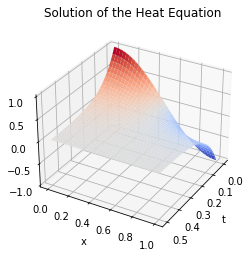

In [ ]:
#%matplotlib inline
#%matplotlib widget
# Plot the numerical solution
plot_heat_solution(x, t, U)

In [ ]:
T, X = np.meshgrid(t, x)
error = u(X, T) - U
print('Maximum error: {:.3e}'.format(max(abs(error.flatten()))))

Maximum error: 3.179e-03


C:\Users\alexl\AppData\Local\Temp\ipykernel_13668\902039532.py:13: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


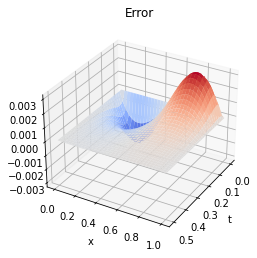

In [ ]:
plot_heat_solution(x, t, error, txt='Error')